In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc


In [38]:
articles = pd.read_csv("data/articles.csv")
cust = pd.read_csv("data/customers.csv")
trans = pd.read_csv("data/transactions_train.csv")

In [39]:
articles.shape

(105542, 25)

In [40]:
## Just a handle of description missing
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [41]:
print(cust.customer_id.nunique())
cust.info()

1371980
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [42]:
cust.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [43]:
trans.shape[0]

31788324

In [44]:
trans.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [45]:
df_trans = trans.copy()
df_trans['year'] = trans.t_dat.apply(lambda date: date.split("-")[0]);
df_trans['month'] = trans.t_dat.apply(lambda date: date.split("-")[1]);


In [46]:
## To split the dataset according to this distribution. Unless we are looking into time series prediction. 
df_trans.year.value_counts(normalize=True)

2019    0.515816
2020    0.345414
2018    0.138770
Name: year, dtype: float64

In [47]:
df_trans[(df_trans['year'] == "2020")]['month'].value_counts(normalize=True)

06    0.160700
05    0.124025
07    0.123086
04    0.122119
08    0.112676
01    0.098027
03    0.095423
02    0.091243
09    0.072701
Name: month, dtype: float64

In [48]:
df_trans[(df_trans['year'] == "2019")]['month'].value_counts(normalize=True)

06    0.116254
07    0.110234
05    0.095159
04    0.090045
03    0.078475
01    0.077055
08    0.076449
09    0.074842
11    0.073064
02    0.070282
10    0.069938
12    0.068203
Name: month, dtype: float64

In [49]:
df_trans[(df_trans['year'] == "2018")]['month'].value_counts(normalize=True)

10    0.316698
11    0.288040
12    0.260430
09    0.134831
Name: month, dtype: float64

In [50]:
# df_train_trans = df_trans.groupby('year', group_keys=False).apply(lambda x: x.sample(frac=0.7))

In [51]:
# df_train_trans['year'].value_counts(normalize=True)

## Calculating customer lifetime value

Getting recency, avg transaction and frequency

In [52]:
df_trans = df_trans.groupby(['t_dat','customer_id']).agg(price=('price', sum)).reset_index()

In [53]:
df = pd.merge(left= cust, right = df_trans,on ='customer_id', how="left")
df.shape

(9089878, 9)

In [54]:
df.head(1)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,t_dat,price
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,2018-12-27,0.110119


In [55]:
df['customer_id'].nunique()

1371980

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9089878 entries, 0 to 9089877
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   customer_id             object 
 1   FN                      float64
 2   Active                  float64
 3   club_member_status      object 
 4   fashion_news_frequency  object 
 5   age                     float64
 6   postal_code             object 
 7   t_dat                   object 
 8   price                   float64
dtypes: float64(4), object(5)
memory usage: 693.5+ MB


In [57]:
df['t_dat'] = pd.to_datetime(df['t_dat'])

In [58]:
df2 = df.groupby(['customer_id']).agg(recency=("t_dat", min), avg_price=("price",np.mean))

In [59]:
df['year'] = df['t_dat'].apply(lambda dat: dat.year)
df.groupby(['customer_id','year']).count().head()

FN  Active  \
customer_id                                        year                 
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2018.0   0       0   
                                                   2019.0   0       0   
                                                   2020.0   0       0   
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0   0       0   
                                                   2019.0   0       0   

                                                           club_member_status  \
customer_id                                        year                         
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2018.0                   1   
                                                   2019.0                   7   
                                                   2020.0                   2   
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0                   4   
                                                   2019.0                  13   

                                                           fashion_news_frequency  \
customer_id                                        year                             
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2018.0                       1   
                                                   2019.0                       7   
                                                   2020.0                       2   
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0                       4   
                                                   2019.0                      13   

                                                           age  postal_code  \
customer_id                                        year                       
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2018.0    1            1   
                                                   2019.0    7            7   
                                                   2020.0    2            2   
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0    4            4   
                                                   2019.0   13           13   

                                                           t_dat  price  
customer_id                                        year                  
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2018.0      1      1  
                                                   2019.0      7      7  
                                                   2020.0      2      2  
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0      4      4  
                                                   2019.0     13     13

In [60]:
df2['freq_per_year'] = df.groupby(['customer_id','year']).count().groupby(['customer_id'])['t_dat'].mean()

In [61]:
latest_trans = df['t_dat'].max()
df2['days_after_last_trans'] = df2['recency'].apply(lambda dat: (latest_trans- dat).days )
df2.head()


,recency,avg_price,freq_per_year,days_after_last_trans
customer_id,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,2018-12-27,0.064898,3.333333,635.0
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,2018-09-21,0.113127,7.666667,732.0
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,2018-09-20,0.100683,2.333333,733.0
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,2019-06-09,0.060983,1.000000,471.0
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,2018-10-12,0.078282,2.000000,711.0


Visualing the distribution

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_price', ylabel='Density'>

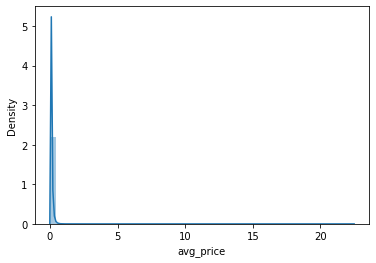

In [62]:
sns.distplot(df2['avg_price'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_price', ylabel='Density'>

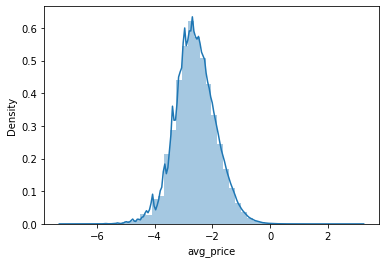

In [63]:
sns.distplot(np.log(df2['avg_price']))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='freq_per_year', ylabel='Density'>

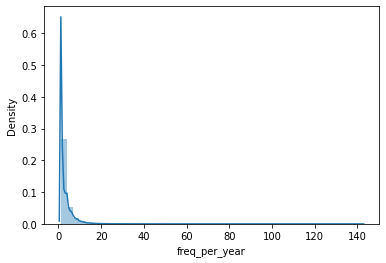

In [64]:
sns.distplot(df2['freq_per_year'])

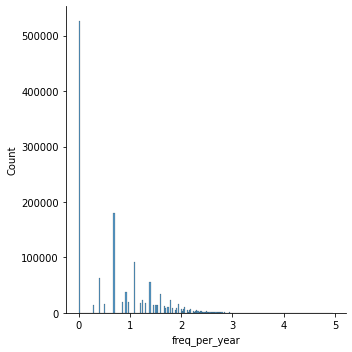

In [65]:
sns.displot(np.log(df2['freq_per_year']))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='days_after_last_trans', ylabel='Density'>

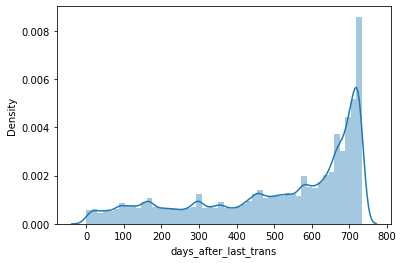

In [66]:
sns.distplot(df2['days_after_last_trans'])

In [67]:
df_trans[df_trans['customer_id'] == df_trans.customer_id.iloc[0]]

,t_dat,customer_id,price
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.081322
45835,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.050831
2034982,2019-03-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.013542
6307717,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.069441
6891191,2020-04-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.135559
7076067,2020-04-18,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.293085
8994749,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.061000


In [71]:
df2 = df2.drop('recency',axis=1).dropna()

In [72]:
from sklearn.cluster import KMeans
cost = []
K = range(1,10)

for num_clusters in list(K):
    kmean = KMeans(n_clusters= num_clusters, init="random", n_init=5, verbose=1)
    kmean.fit(df2)
    cost.append(kmean.inertia_)

Initialization complete
Iteration 0, inertia 66535608111.84455.
Iteration 1, inertia 62639009027.816925.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 125882078491.64793.
Iteration 1, inertia 62639009027.816925.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 66767523701.427.
Iteration 1, inertia 62639009027.816925.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 74563907529.65083.
Iteration 1, inertia 62639009027.816925.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 359156998520.0312.
Iteration 1, inertia 62639009027.816925.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 30920686792.29019
Iteration 1, inertia 16248114734.235538
Iteration 2, inertia 14251833133.100477
Iteration 3, inertia 13748298097.390436
Iteration 4, inertia 13535826085.45076
Iteration 5, inertia 134

<function matplotlib.pyplot.show(close=None, block=None)>

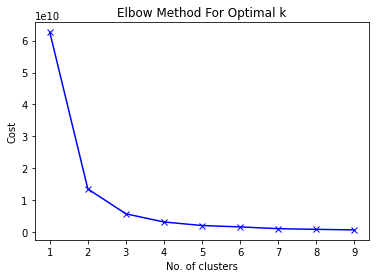

In [73]:
plt.plot(K,cost,'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title("Elbow Method For Optimal k")
plt.show
# Optimal cluster to be at cluster 7

In [74]:
#clustering at 3 clusters
kmean = KMeans(n_clusters= 3, init="random", n_init=5, verbose=1)
kmean.fit(df2)
df2['cluster'] = kmean.predict(df2)
df2['cluster'].head()

Initialization complete
Iteration 0, inertia 15661188895.174305
Iteration 1, inertia 7014688707.246445
Iteration 2, inertia 6286297339.812096
Iteration 3, inertia 5946665078.259229
Iteration 4, inertia 5805571150.641117
Iteration 5, inertia 5747280182.641142
Iteration 6, inertia 5716679806.072136
Iteration 7, inertia 5701316838.172468
Iteration 8, inertia 5693440123.505728
Iteration 9, inertia 5689322990.032068
Iteration 10, inertia 5687958175.512442
Converged at iteration 10: center shift 0.9300467813826323 within tolerance 1.5326991770392342.
Initialization complete
Iteration 0, inertia 20218528992.96573
Iteration 1, inertia 5837509160.105665
Iteration 2, inertia 5687060909.109297
Iteration 3, inertia 5680532272.465584
Converged at iteration 3: center shift 1.3453076948016083 within tolerance 1.5326991770392342.
Initialization complete
Iteration 0, inertia 13423401952.323305
Iteration 1, inertia 9111201369.305933
Iteration 2, inertia 7176471172.753468
Iteration 3, inertia 6383802456.

customer_id
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657    0
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa    0
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318    0
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e    2
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a    0
Name: cluster, dtype: int32

In [76]:
df2.head()

,avg_price,freq_per_year,days_after_last_trans,cluster
customer_id,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0.064898,3.333333,635.0,0
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,0.113127,7.666667,732.0,0
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0.100683,2.333333,733.0,0
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0.060983,1.000000,471.0,2
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0.078282,2.000000,711.0,0


Text(0.5, 0, 'Days after last trans')

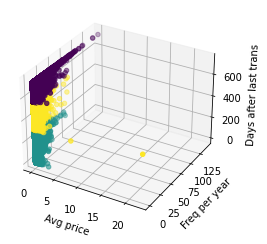

In [81]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(df2['avg_price'], df2['freq_per_year'],  df2['days_after_last_trans'], c= df2['cluster'])
ax.set_xlabel('Avg price')
ax.set_ylabel('Freq per year')
ax.set_zlabel('Days after last trans')

<AxesSubplot:xlabel='days_after_last_trans', ylabel='freq_per_year'>

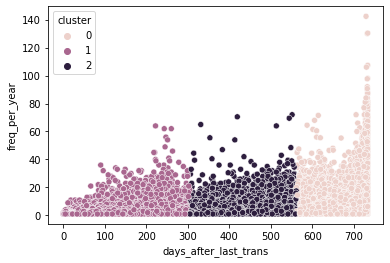

In [88]:
sns.scatterplot(y= df2['freq_per_year'], x= df2['days_after_last_trans'], hue = df2['cluster'])